In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import scipy.spatial.distance as dist
%matplotlib inline

### Section 1.1 - Importing the Data

Let's begin in the same way we did for Assignment \#2 of 2014, but this time let's start with importing the temperature data:

In [53]:
temperatureDateConverter = lambda d : dt.datetime.strptime(d,'%Y-%m-%d %H:%M:%S')
temperature = np.genfromtxt('../../../data/temperature.csv',delimiter=",",dtype=[('timestamp', type(dt.datetime.now)),('tempF', 'f8')],converters={0: temperatureDateConverter}, skiprows=1)

Notice that, because we are asking for the data to be interpreted as having different types for each column, and the the numpy.ndarray can only handle homoegenous types (i.e., all the elements of the array must be of the same type) then the resulting array is a one dimensional ndarray of tuples. Each tuple corresponds to a row in the file and in it, then, are the three columns for the row.

Formally, this is called a Structured Array and is something you should read up on if you want to fully understand what it means and how to handle these types of data structures:

https://docs.scipy.org/doc/numpy/user/basics.rec.html

In [4]:
print "The variable 'temperature' is a " + str(type(temperature)) + " and it has the following shape: " + str(temperature.shape)

The variable 'temperature' is a <type 'numpy.ndarray'> and it has the following shape: (105409,)


Fortunately, these structured arrays allow us to access the content inside the tuples directly by calling the field names. Let's figure out what those field names are:

In [5]:
temperature.dtype.fields

<dictproxy {'tempF': (dtype('float64'), 8), 'timestamp': (dtype('O'), 0)}>

Now let's see what the timestamps look like, for this dataset:

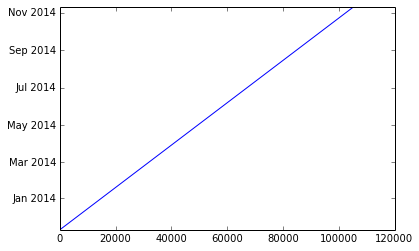

In [6]:
plt.plot(temperature['timestamp'])

Seems as if there are no gaps, but let's make sure about that. First, let's compute the minimum and maximum difference between any two consecutive timestamps:

In [7]:
print "The minimum difference between any two consecutive timestamps is: " + str(np.min(np.diff(temperature['timestamp'])))
print "The maximum difference between any two consecutive timestamps is: " + str(np.max(np.diff(temperature['timestamp'])))      

The minimum difference between any two consecutive timestamps is: 0:05:00
The maximum difference between any two consecutive timestamps is: 0:05:00


Given that they both are 5 minutes, then it means that there really is no gap in the datset, and all temperature measurements were taken 5 minutes apart.

Since we need temperature readings every 15 minutes we can downsample this dataset. There are many ways to do the downsampling, and it is important to understand the effects each of them may have on the final result we are seeking. However, this is beyond the scope of the class, so I will pick a very naïve approach and simply select every third sample:

In [54]:
temperature = temperature[0:-1:3]

Finally, let's make a note of when the first and last timestamp are:

In [29]:
print "First timestamp is on \t{}. \nLast timestamp is on \t{}.".format(temperature['timestamp'][0], temperature['timestamp'][-1])

First timestamp is on 	2013-11-10 05:00:00. 
Last timestamp is on 	2014-11-11 04:45:00.


#### Loading the Power Data

Just as we did before, we start with the genfromtxt function:

In [9]:
dateConverter = lambda d : dt.datetime.strptime(d,'%Y/%m/%d %H:%M:%S')
power = np.genfromtxt('../../../data/campusDemand.csv',delimiter=",",names=True,dtype=['S255',dt.datetime,'f8'],converters={1: dateConverter})

Let's figure out how many meters there are, and where they are in the ndarray, as well as how many datapoints they have.

In [10]:
name, indices, counts  = np.unique(power['Point_name'], return_index=True,return_counts=True)

Now let's print that information in a more readable fashion:

In [11]:
for i in range(len(name)):
    print str(name[i])+"\n\t from "+str(power[indices[i]]['Time'])+" to "+str(power[indices[i]+counts[i]-1]['Time'])+"\n\t or "+str(power[indices[i]+counts[i]-1]['Time']-power[indices[i]]['Time'])
    

Baker Hall Electric (Shark 29) - Demand Watts 
	 from 2014-02-12 07:03:27 to 2014-11-10 22:04:28
	 or 271 days, 15:01:01
Baker Hall Electric (Shark 29) - Watts
	 from 2014-11-03 00:00:24 to 2014-11-10 22:43:28
	 or 7 days, 22:43:04
Doherty Apts Electric (Shark 11) - Demand Watts
	 from 2014-10-10 09:13:56 to 2014-11-10 21:52:28
	 or 31 days, 12:38:32
Electric kW Calculations - Main Campus kW
	 from 2013-11-10 00:00:30 to 2014-11-10 22:53:27
	 or 365 days, 22:52:57
Porter Hall Electric (Shark 30) - Watts
	 from 2014-09-10 00:00:50 to 2014-11-10 22:42:28
	 or 61 days, 22:41:38
Scaife Hall Electric (Shark 21) - Watts
	 from 2014-10-10 00:00:15 to 2014-11-10 22:45:28
	 or 31 days, 22:45:13
University Center Electric (Shark 34) - Watts
	 from 2014-11-03 00:00:24 to 2014-11-10 22:48:28
	 or 7 days, 22:48:04


Since only one meter needs to be used, pick the one you like and discard the rest:

In [12]:
power=power[power['Point_name']==name[3]]

Let's make sure the data is sorted by time and then let's plot it

In [13]:
power = np.sort(power,order='Time')

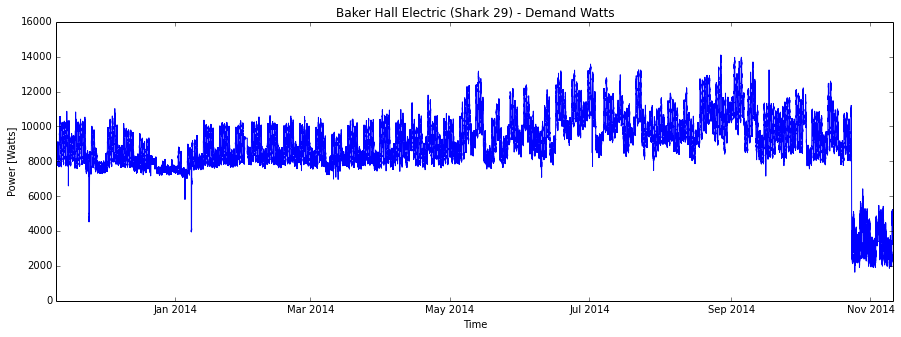

In [14]:
fig1= plt.figure(figsize=(15,5))
plt.plot(power['Time'],power['Value'])
plt.title(name[0])
plt.xlabel('Time')
plt.ylabel('Power [Watts]')

Are there gaps in this dataset?

In [15]:
power = np.sort(power,order='Time')
print "The minimum difference between any two consecutive timestamps is: " + str(np.min(np.diff(power['Time'])))
print "The maximum difference between any two consecutive timestamps is: " + str(np.max(np.diff(power['Time'])))      

The minimum difference between any two consecutive timestamps is: 0:00:00
The maximum difference between any two consecutive timestamps is: 1 day, 2:50:49


And when is the first and last timestamp for this dataset? (We would like them to overlap as much as possible):

In [30]:
print "First timestamp is on \t{}. \nLast timestamp is on \t{}.".format(power['Time'][0], power['Time'][-1])

First timestamp is on 	2013-11-10 00:00:30. 
Last timestamp is on 	2014-11-10 22:53:27.


So let's summarize the differences in terms of the timestamps:

* There is at least one significant gap (1 day and a few hours), and there's also a strange situation that causes two consecutive samples to have the same timestamp (i.e., the minimum difference is zero).

* The temperature dataset starts a little later, and ends almost a full day later than the power dataset.

Yes, this is incovnenient, I know. It is painful to know that not only are the two datasets sampled at different rates, but they are also of different lengths of time and one of them has gaps. 

This is what real data looks like, in case you were wondering.

At this point, one of the simplest ways to move forward without having to re-invent the wheel would be to rely on the help of more powerful libraries such as **Pandas**. 

However, just to make things more fun and instructional, I am going to go through the trouble of implementing a interpolation function myself and will use it to obtain power values at exactly the same timestamps as the temperature data is providing.

In other words, let's assume that the timestamps for the temperature data are $t^T_i$ $\forall i \in [1, 2, \ldots n_T]$, and that the timestamps for the power data are $t^P_i$ $\forall i \in [1, 2, \ldots n_P]$, where $n_T$ and $n_P$ are the number of records in the temperature and power datasets, respectively. What I am interested in doing is finding the values of power $P$ at exactly all of the $n_T$ temperature timestamps, i.e. find $P(t^T_i)$ $\forall i$.

We will do all of these things in the next section.

### Harmonizing the time series

First let's remember what times the two time series (power and temperature) start and end:

In [40]:
print "Power data from {0} to {1}.\nTemperature data from {2} to {3}".format(power['Time'][0], power['Time'][-1], temperature['timestamp'][0], temperature['timestamp'][-1])

Power data from 2013-11-10 00:00:30 to 2014-11-10 22:53:27.
Temperature data from 2013-11-10 05:00:00 to 2014-11-10 22:45:00


Clearly, we don't need the portion of the temperature data that is collected beyond the dates that we have power data. Let's remove this (note that the magic number 24 corresponds to 360 minutes or 6 hours):

In [55]:
temperature = temperature[0:-24] 

Now let's create the interpolation function:

In [41]:
def power_interp(tP, P, tT):
    # This function assumes that the input is an numpy.ndarray of datetime objects

    # Most useful interpolation tools don't work well with datetime objects
    # so we convert all datetime objects into the number of seconds elapsed
    # since 1/1/1970 at midnight (also called the UNIX Epoch, or POSIX time):
    
    toposix = lambda d: (d - dt.datetime(1970,1,1,0,0,0)).total_seconds()
    tP = map(toposix, tP)
    tT = map(toposix, tT)
    
    # Now we interpolate
    from scipy.interpolate import interp1d
    f = interp1d(tP, P,'linear')
    
    return f(tT)
    

And let's use that funciton to get a copy of the interpolated power values, extracted at exactly the same timestamps as the temperature dataset:

In [44]:
newPowerValues = power_interp(power['Time'], power['Value'], temperature['timestamp'])

Finally, to keep things simple, let's restate the variables that matter:

In [153]:
toposix = lambda d: (d - dt.datetime(1970,1,1,0,0,0)).total_seconds()

timestamp_in_seconds = map(toposix,temperature['timestamp'])
timestamps = temperature['timestamp']
temp_values = temperature['tempF']
power_values = newPowerValues

And let's plot it to see what it looks like.

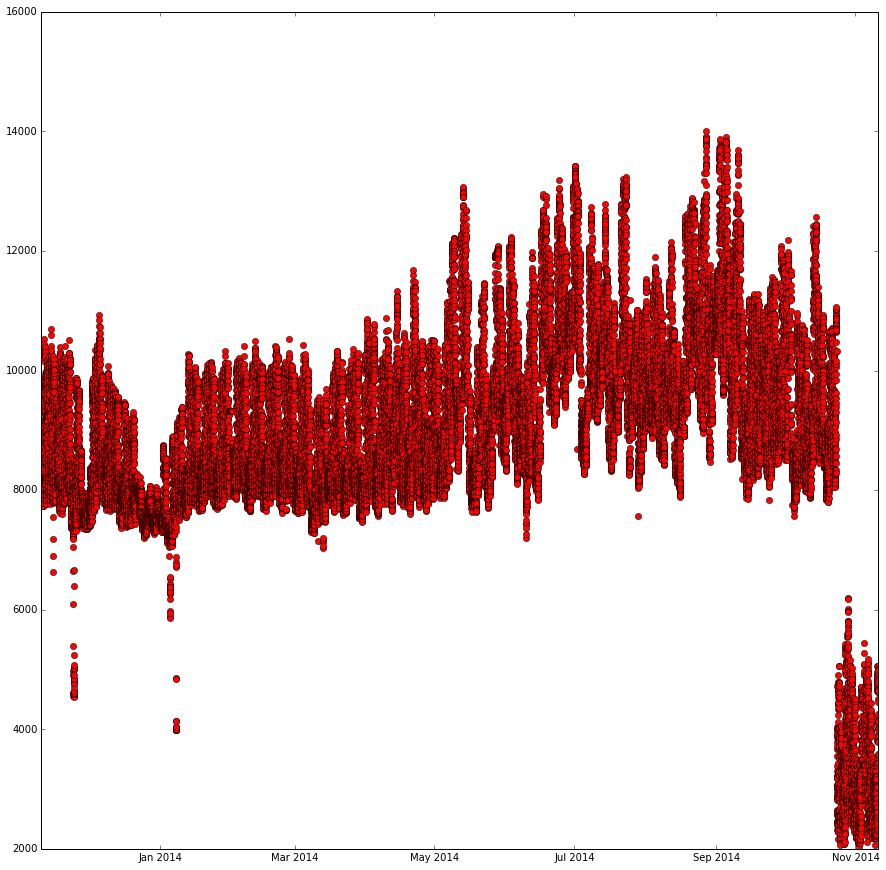

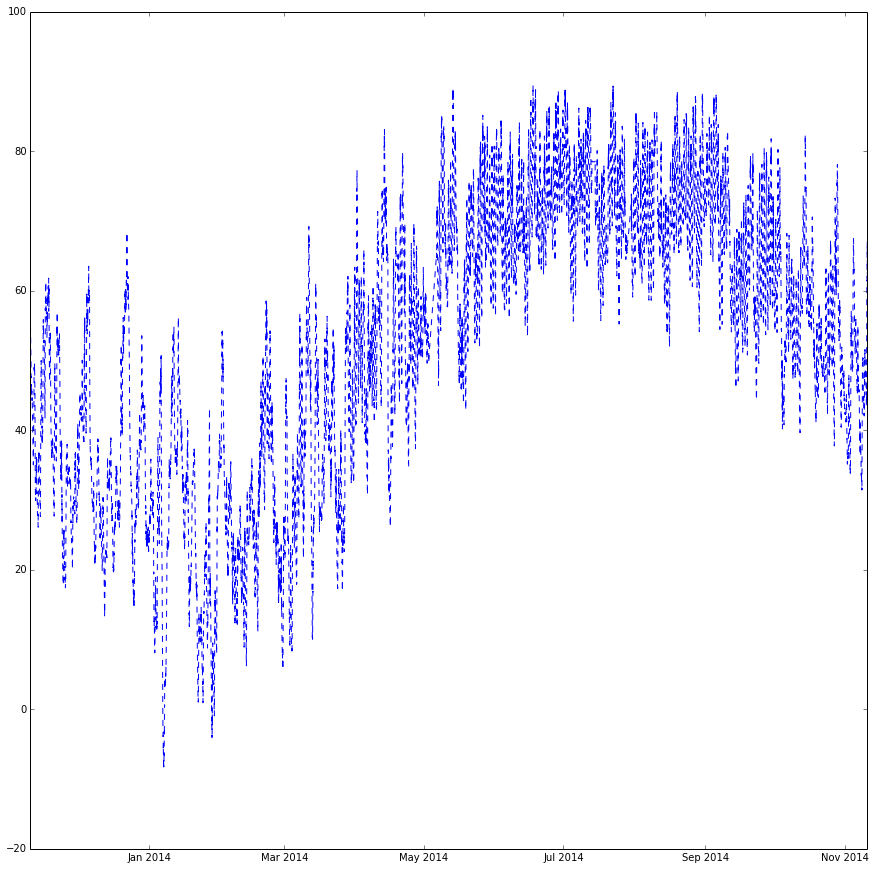

In [158]:
plt.figure(figsize=(15,15))
plt.plot(timestamps,power_values,'ro')
plt.figure(figsize=(15,15))
plt.plot(timestamps, temp_values, '--b')

## Task \#1

Now let's put all of this data into a single structured array.

## Task \#2

Since we have the timestamps in '*datetime*' format we can easily do the extraction of the indeces:

## Task \#3

Similar as in the previous task...